# ```Model Training and Evaluation with Oversampling```

Importing all libraries that'll be required.


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC 
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from typing import Counter
from catboost import CatBoostClassifier as CBC
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline


In [76]:
# # Surpress warnings:
# import warnings
# def warn(*args, **kwargs):
#     pass
# warnings.warn = warn


This function plots the confusion matrices given y_i, y_i_hat.

In [77]:
def plot_confusion_matrix(y, y_predict, t='Confusion Matrix', cm=None):
    if cm is None:
        cm = confusion_matrix(y, y_predict)
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, ax=ax, cmap='mako', fmt=',d').set_title(
        t, fontsize=12)
    # sns.color_palette("mako", as_cmap=True)
    ax.set_xlabel('Predicted labels', fontsize=10)
    ax.set_ylabel('True labels', fontsize=10)
    ax.xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    ax.yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    plt.show()


This function plots the barplot of the scores of the models for each overrsampling technique.

In [102]:
def resplot(res, title):
    bplot = res.plot(kind='bar', width=0.8, colormap='mako',
                   figsize=(14, 4), title=title, legend=False, fontsize=10)
    for bar in bplot.patches:
        bplot.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()-0.02), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    bplot.legend(bbox_to_anchor=(1.0, 1), fontsize='medium')
    bplot.title.set_size(15)
    plt.xticks(rotation=0)
    plt.show()


This function returns a list of the scores for a given model trained using various oversampling techniques.

In [79]:
def report1(yt, y_pred):
    rep = [accuracy_score(yt, y_pred), precision_score(
        yt, y_pred), recall_score(yt, y_pred), f1_score(yt, y_pred)]
    # print(rep)
    return rep

This function plots the roc curve given y_i, y_i_prob.

In [80]:
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


This function prints the report for a given model, and returns a dataframe with the scores.

In [81]:
def report(yt, y_pred):
    d = {"Accuracy": accuracy_score(yt, y_pred),
         "Precision": precision_score(yt, y_pred),
         "Recall": recall_score(yt, y_pred),
         "F1 score": f1_score(yt, y_pred)}
    rep = pd.DataFrame(d, index=[0])
    print(rep)
    return rep


This function plots the confusion matrices in a grid format given y_i, y_i_hat or a confusion matrix.

In [82]:
def plot_confusion_grid(y, y_predict, t='Confusion Matrices', cm=None):
    if cm is None:
        cm = confusion_matrix(y, y_predict)
    fig, axx = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    ost=['ROS', 'SMOTE', 'ADASYN']
    for i in range(3):
            sns.heatmap(cm[i], annot=True, ax=axx[i], cmap='mako', fmt=',d').set_title(
                f"{ost[i]} Oversampling", fontsize=12)
            axx[i].set_xlabel('Predicted labels', fontsize=10)
            axx[i].set_ylabel('True labels', fontsize=10)
            axx[i].xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
            axx[i].yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    fig.tight_layout(pad=4.0)
    fig.suptitle(t, fontsize=20)
    plt.show()

Loading the datasets

In [83]:
df = pd.read_csv('train40Features.csv')
target = pd.read_csv('train.csv')

In [84]:
# df.head()

In [85]:
# target.head()

In [86]:
# df.isnull().sum()

In [87]:
# for i in range(len(df.columns)):
#     if df.iloc[:,i].isnull().sum():
#         print(df.columns[i])

In [88]:
for i in range(len(target.columns)):
    if target.iloc[:, i].isnull().sum():
        print(target.columns[i], target.iloc[:, i].isnull().sum())


sex 65
age_approx 68
anatom_site_general_challenge 527


In [89]:
df['target'] = target['target']

In [90]:
df.drop('V1',axis = 1, inplace = True) 

In [91]:
columns = ['sex','age','anatomy','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8','V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34','V35','V36','target']
df.columns = columns
# df.head()

In [92]:
# df.drop(['anatomy', 'sex', 'age'],axis = 1, inplace = True)

In [93]:
df.head()

,sex,age,anatomy,V1,V2,V3,V4,V5,V6,V7,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,target
0,3,45.0,2,9,8789.0625,84.667969,147,1435.546875,2.148438,0.074062,...,1.428571,1.176471,0.368451,24.984602,1.309416,0.272855,0.098885,52.594848,0.428426,0
1,2,45.0,7,5,4882.8125,84.570312,88,859.375000,1.687500,0.074457,...,1.666667,1.095238,0.391409,25.587810,1.240345,0.317342,0.125999,57.991760,0.430091,0
2,2,50.0,3,6,5859.3750,84.960938,100,976.562500,1.781250,0.074682,...,1.531477,0.581197,0.209879,14.387222,1.272196,0.410767,0.138850,56.623874,0.423386,0
3,2,45.0,2,15,14648.4375,84.765625,210,2050.781250,2.640625,0.075285,...,1.000000,2.000000,0.643102,47.842749,1.504529,0.830075,0.271822,46.900691,0.425073,0
4,2,55.0,7,6,5859.3750,84.667969,98,957.031250,1.765625,0.074475,...,1.479167,1.100000,0.361749,23.899347,1.310327,0.357306,0.125601,57.289260,0.428426,0


# Over Sampling Techniques

Dictionaries to store the training and testing data for each oversampling technique

In [94]:
x = {}
y = {}
x_train = {}
x_test = {}
y_train = {}
y_test = {}

### 1. RandomOverSampler Oversampling

In [95]:
ros=RandomOverSampler(random_state=0, sampling_strategy=0.04)
x['ROS'], y['ROS']= ros.fit_resample(df.drop('target',axis=1),df['target'])
x_train['ROS'], x_test['ROS'], y_train['ROS'], y_test['ROS'] = train_test_split(x['ROS'], y['ROS'], test_size=0.25, random_state=42)
print(y_train['ROS'].value_counts(),'\n',y_test['ROS'].value_counts())
st_x= StandardScaler()    
x_train['ROS']= st_x.fit_transform(x_train['ROS'])    
x_test['ROS']= st_x.transform(x_test['ROS']) 

target
0    24402
1      980
Name: count, dtype: int64 
 target
0    8140
1     321
Name: count, dtype: int64


* the dataset is oversampled fom 1:70 class ratio to 1:25 class ratio

### 2. Synthetic Minority Oversampling TEchnique (SMOTE)

In [96]:
smote= SMOTE(random_state=0, sampling_strategy=0.08)
x['SMOTE'], y['SMOTE']= smote.fit_resample(df.drop('target',axis=1),df['target'])
x_train['SMOTE'], x_test['SMOTE'], y_train['SMOTE'], y_test['SMOTE'] = train_test_split(x['SMOTE'], y['SMOTE'], test_size=0.25, random_state=42)
print(y_train['SMOTE'].value_counts(),'\n',y_test['SMOTE'].value_counts())
st_x= StandardScaler()
x_train['SMOTE']= st_x.fit_transform(x_train['SMOTE'])
x_test['SMOTE']= st_x.transform(x_test['SMOTE'])

target
0    24416
1     1942
Name: count, dtype: int64 
 target
0    8126
1     661
Name: count, dtype: int64


The dataset is oversampled using SMOTE to 2:25 class ratio

### 3. Adaptive Synthetic (ADASYN) Oversampling

In [97]:
adasyn= ADASYN(random_state=0, sampling_strategy=0.08)
x['ADASYN'], y['ADASYN']= adasyn.fit_resample(df.drop('target',axis=1),df['target'])
x_train['ADASYN'], x_test['ADASYN'], y_train['ADASYN'], y_test['ADASYN'] = train_test_split(x['ADASYN'], y['ADASYN'], test_size=0.25, random_state=42)
print(y_train['ADASYN'].value_counts(),'\n',y_test['ADASYN'].value_counts())
st_x= StandardScaler()
x_train['ADASYN']= st_x.fit_transform(x_train['ADASYN'])
x_test['ADASYN']= st_x.transform(x_test['ADASYN'])

target
0    24360
1     2166
Name: count, dtype: int64 
 target
0    8182
1     660
Name: count, dtype: int64


The dataset is oversampled using ADASYN to 2:25 class ratio

Printing the class counts for each oversampling technique in training and testing data

In [98]:
ost = ['ROS', 'SMOTE', 'ADASYN']
ostindex=['RandomOverSampler', 'SMOTE', 'ADASYN']
metric =['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i in ost:
    print(i, x_train[i].shape, x_test[i].shape,
          y_train[i].shape, y_test[i].shape)
    print(Counter(y_train[i]), Counter(y_test[i]), "\n\n")


ROS (25382, 39) (8461, 39) (25382,) (8461,)
Counter({0: 24402, 1: 980}) Counter({0: 8140, 1: 321}) 


SMOTE (26358, 39) (8787, 39) (26358,) (8787,)
Counter({0: 24416, 1: 1942}) Counter({0: 8126, 1: 661}) 


ADASYN (26526, 39) (8842, 39) (26526,) (8842,)
Counter({0: 24360, 1: 2166}) Counter({0: 8182, 1: 660}) 




# Logistic Regression

In [99]:
cmm = []
lrres=[]
ust = ['ROS', 'SMOTE', 'ADASYN']
clf = LogisticRegression()
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    lrres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Oversampling :")
    # report(y_test[i], y_pred)
    # print("\n")


c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [100]:
lrres = pd.DataFrame(lrres)
lrres.index = ostindex
lrres.columns = metric
lrres

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.962179,0.666667,0.006231,0.012346
SMOTE,0.942415,0.928177,0.254160,0.399050
ADASYN,0.943339,0.949153,0.254545,0.401434


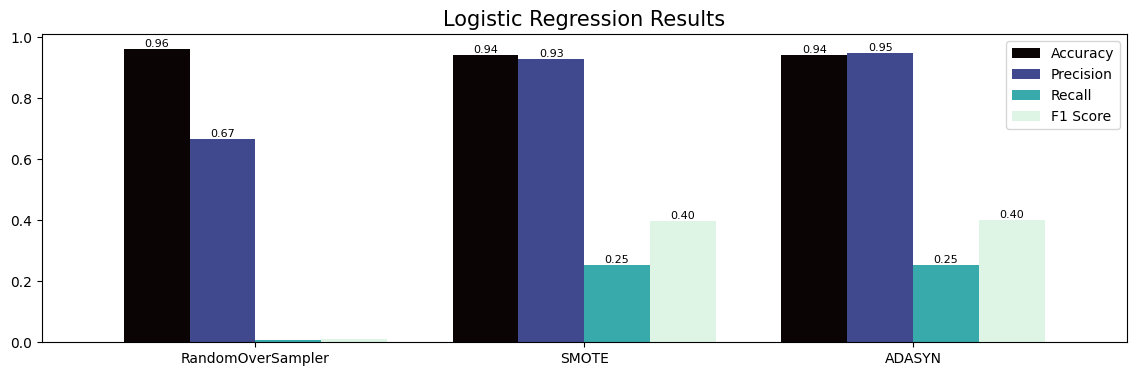

In [101]:
resplot(lrres, 'Logistic Regression Results')

In [28]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'LGR CM with {ust[n]} oversampling', cm=i)


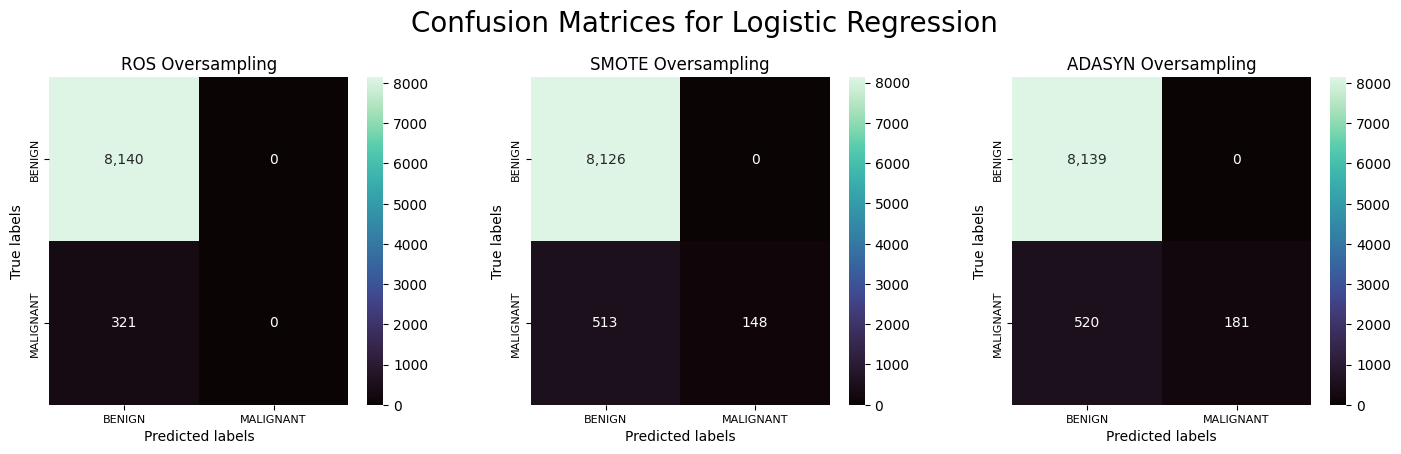

In [29]:
plot_confusion_grid(0,0, cm=cmm, t='Confusion Matrices for Logistic Regression')

* Logistic regression does not perform well for ROS, giving a 0 F1 score.<br>
* It performs sub par for SMOTE and ADASYN, giving a 0.4 and 0.5 F1 score respectively for the oversampling techniques.

# Decision Tree Classifier

In [30]:
cmm = []
clf = DecisionTreeClassifier(splitter='best')
dtcres=[]
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    dtcres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i],y_pred))
    # print(i+" Oversampling :")
    # report(y_test[i], y_pred)
    # print("\n")
# print(cmm)


In [31]:
dtcres=pd.DataFrame(dtcres)
dtcres.index=ostindex
dtcres.columns=metric
dtcres

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.968325,0.556025,0.819315,0.662469
SMOTE,0.921475,0.479016,0.500756,0.489645
ADASYN,0.918552,0.486639,0.493581,0.490085


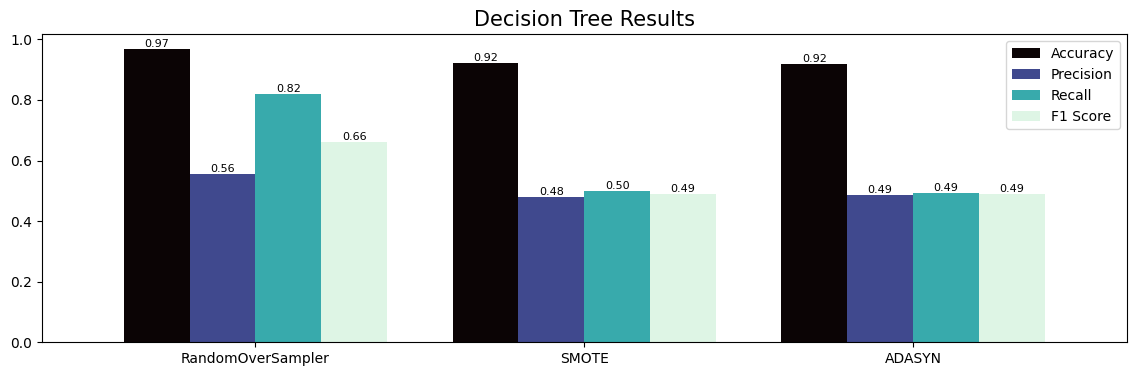

In [32]:
resplot(dtcres, 'Decision Tree Results')

In [33]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'DTC CM with {ust[n]} oversampling', cm=i)


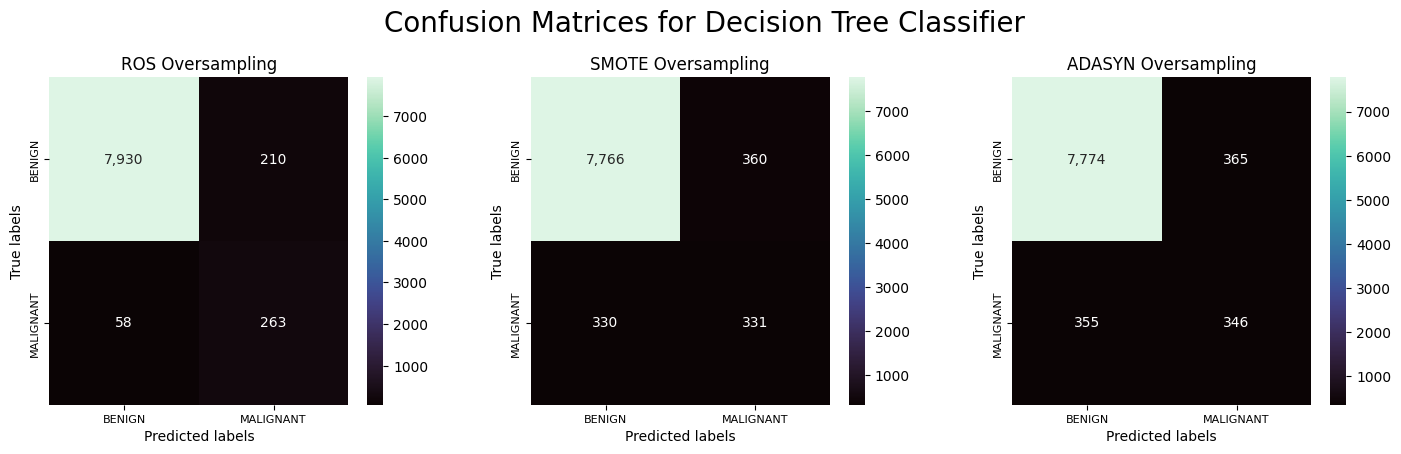

In [34]:
plot_confusion_grid(0,0, cm=cmm, t='Confusion Matrices for Decision Tree Classifier')

* DTC performs okayish for ROS, giving a 0.66 F1 score.<br>
* For SMOTE and ADASYN, DTC has a 0.49 F1 score.

# K Nearest Neighbors Classifier

In [35]:
clf = KNeighborsClassifier(n_neighbors=6)
cmm = []
knnres=[]
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    knnres.append(report1(y_test[i], y_pred))
    # print(i+" Oversampling :")
    # report(y_test[i], y_pred)
    # print("\n")


In [36]:
knnres=pd.DataFrame(knnres)
knnres.index=ostindex
knnres.columns=metric
knnres

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.959816,0.373333,0.087227,0.141414
SMOTE,0.936497,0.654655,0.329803,0.438632
ADASYN,0.934729,0.653465,0.376605,0.477828


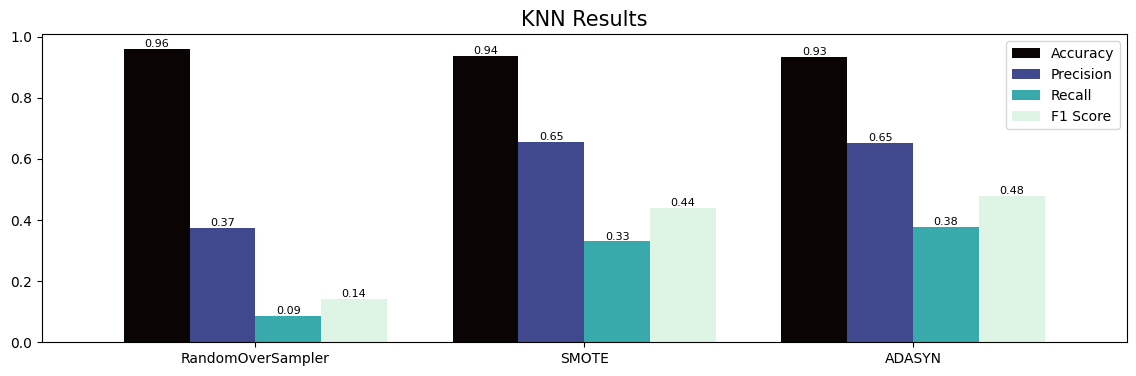

In [37]:
resplot(knnres, 'KNN Results')

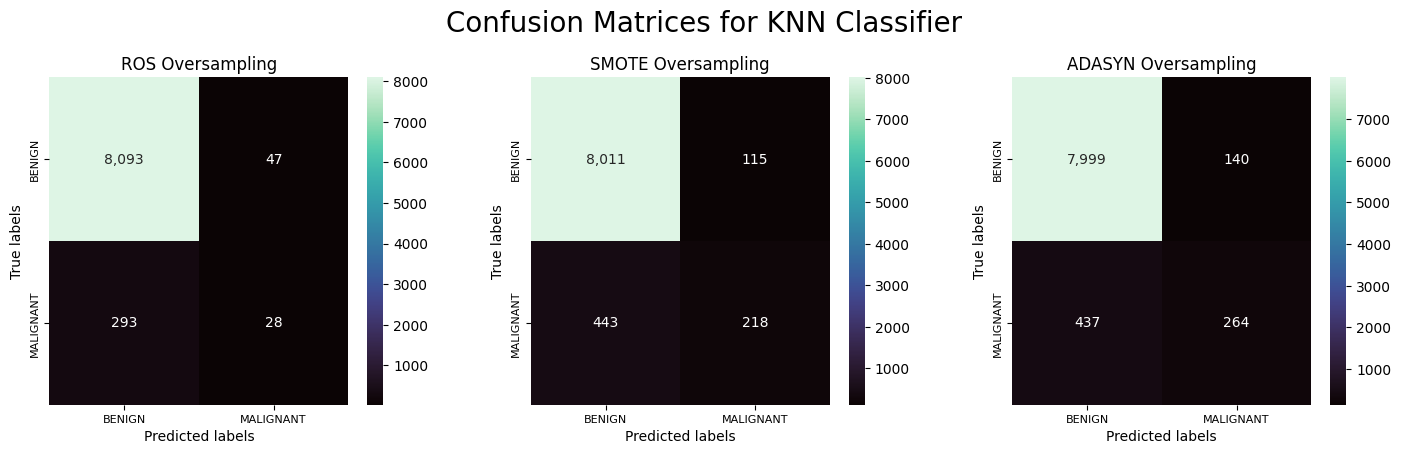

In [38]:
plot_confusion_grid(0,0, cm=cmm, t='Confusion Matrices for KNN Classifier')

* KNN does not give proper results for ROS, giving a 0.14 F1 score.<br>
* For SMOTE and ADASYN, KNN has a 0.44 and 0.48 F1 score respectively.<br>
* Overall KNN doesnot perform well.

In [39]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'KNN CM with {ust[n]} oversampling', cm=i)


## Support Vector Classifier

In [40]:
cmm = []
clf = SVC()
svmres=[]
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    svmres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Undersampling :")
    # report(y_test[i], y_pred)
    # print("\n")


c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
svmres=pd.DataFrame(svmres)
svmres.index=ostindex
svmres.columns=metric
svmres

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.962061,0.0,0.00000,0.000000
SMOTE,0.924775,0.0,0.00000,0.000000
ADASYN,0.921041,1.0,0.00428,0.008523


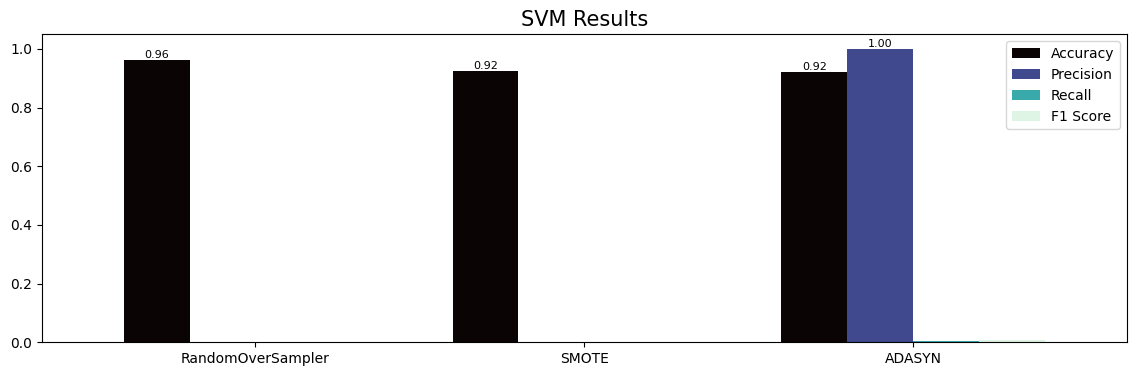

In [42]:
resplot(svmres, 'SVM Results')

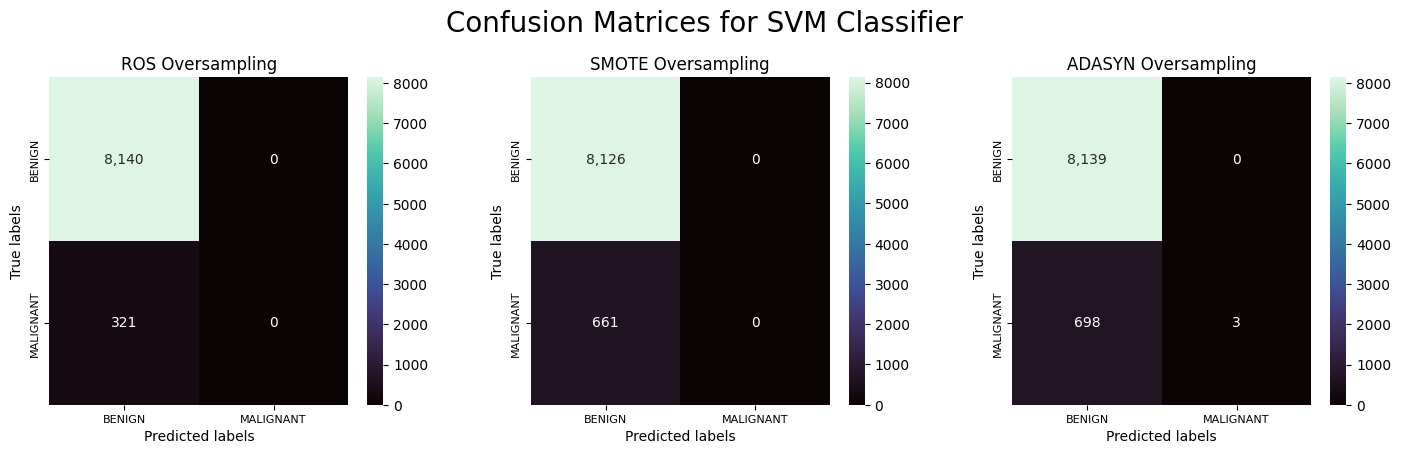

In [43]:
plot_confusion_grid(0,0, cm=cmm, t='Confusion Matrices for SVM Classifier')

As we can see, SVM is unable to classify for any for the oversampling techniques, and has a very low F1 score. This may be due to the fact that the dataset is not linearly separable and also the dataset is realtively large for SVM to perform well.

In [44]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'SVC CM with {ust[n]} oversampling', cm=i)


## Random Forest Classifier

In [45]:
cmm=[]
rfcres=[]
for i in ust:
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(x_train[i], y_train[i])
    y_pred = rfc.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    rfcres.append(report1(y_test[i], y_pred))
    # print(i+" Oversampling :")
    # report(y_test[i], y_pred)
    # print("\n")

In [46]:
rfcres=pd.DataFrame(rfcres)
rfcres.index=ostindex
rfcres.columns=metric
rfcres

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.991845,0.970149,0.809969,0.882852
SMOTE,0.953795,0.956989,0.403933,0.568085
ADASYN,0.954977,0.963303,0.449358,0.612840


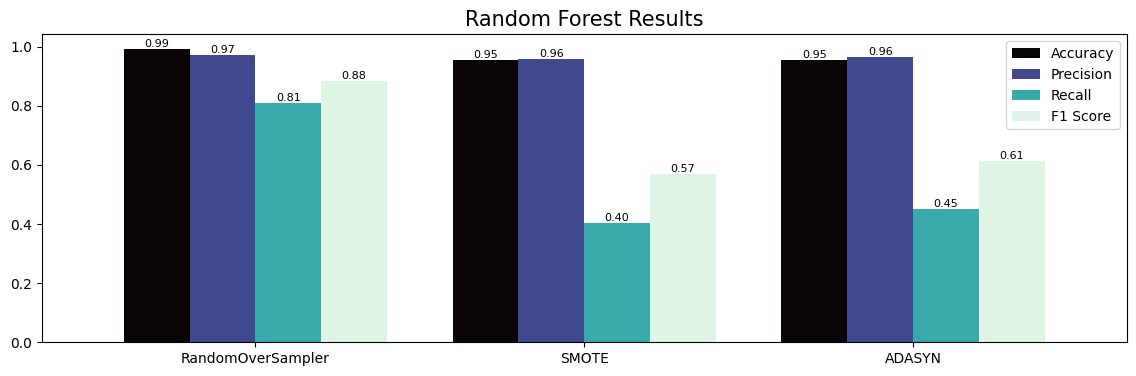

In [47]:
resplot(rfcres, 'Random Forest Results')

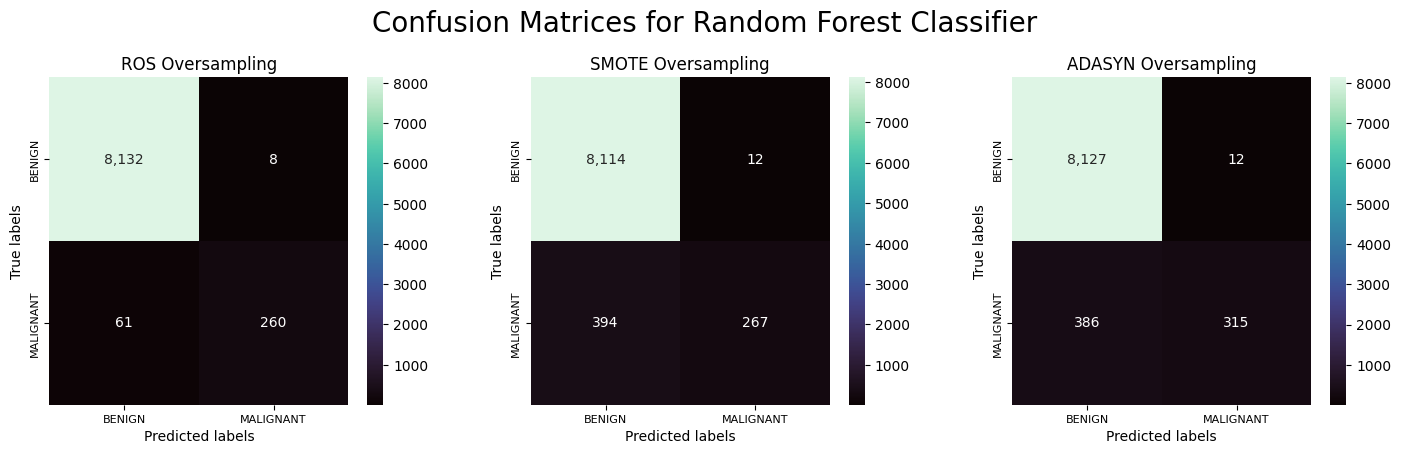

In [48]:
plot_confusion_grid(0,0, cm=cmm, t='Confusion Matrices for Random Forest Classifier')

* RFC perfoms well for ROS, giving a 0.82  F1 score. This may be due to the fact the data is randomly duplicated hence it might have overfit the data<br>
* It has a f1 score of around 0.6 for SMOTE and ADASYN.

In [49]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'RFC CM with {ust[n]} oversampling', cm=i)

## XGBoost Classifier

In [50]:
cmm = []
xgbres = []
for i in ost:
    clf = XGBClassifier()
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    xgbres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Oversampling :")
    # report(y_test[i], y_pred)
    # print("\n")


In [51]:
xgbres = pd.DataFrame(xgbres)
xgbres.index = ostindex
xgbres.columns = metric
xgbres

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.986999,0.977376,0.672897,0.797048
SMOTE,0.977239,0.991471,0.703480,0.823009
ADASYN,0.976923,0.990138,0.716120,0.831126


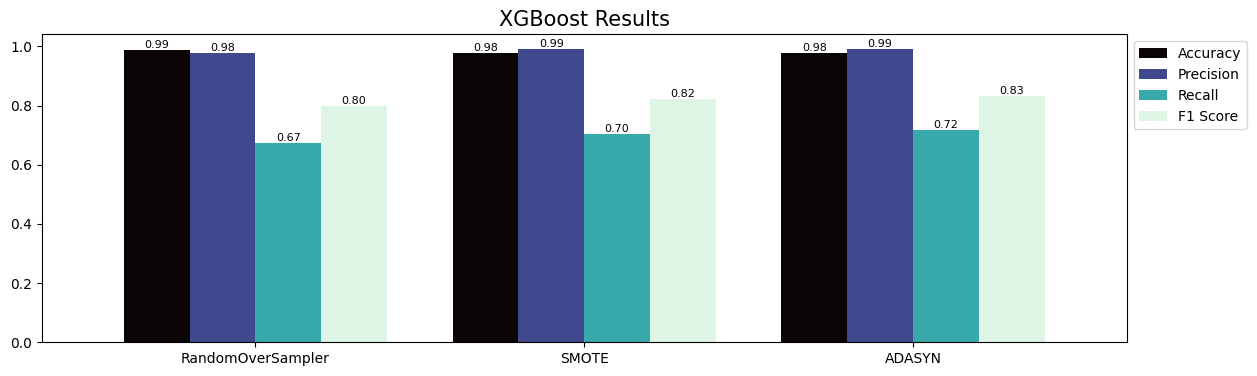

In [52]:
resplot(xgbres, 'XGBoost Results')

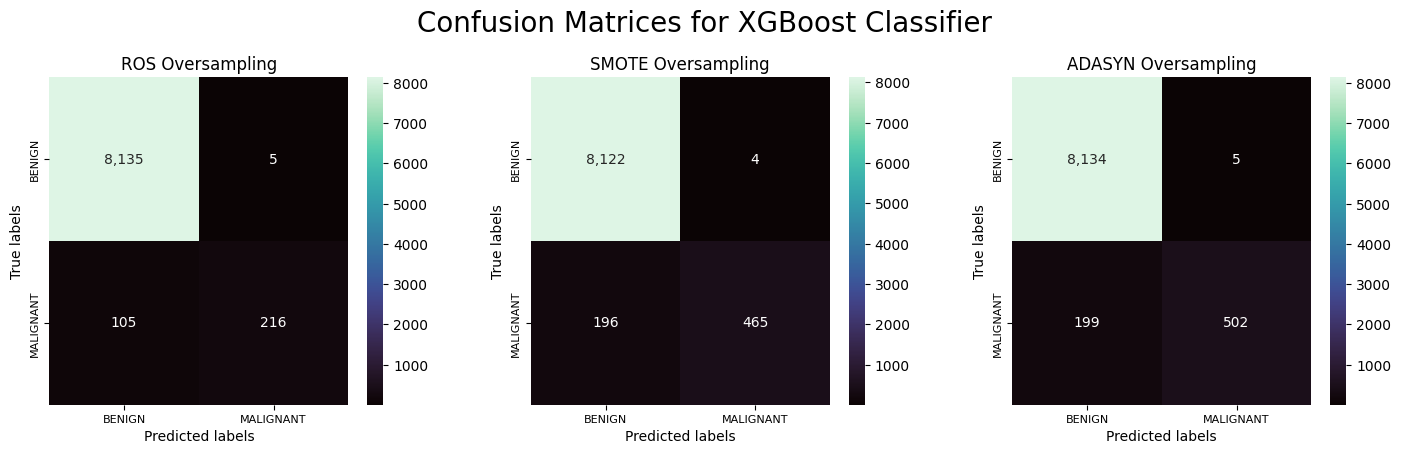

In [53]:
plot_confusion_grid(0, 0, cm=cmm, t='Confusion Matrices for XGBoost Classifier')

* XGBOOST perfoms decent for all the oversampling techniques, having a ~0.8 f1 score for each ROS, SMOTE and ADASYN.

In [54]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'XBGC CM with {ust[n]} oversampling', cm=i)


## LightGBM Classifier

In [55]:
cmm=[]
lgbmres=[]
clf = LGBMClassifier(learning_rate=0.25, n_estimators=100, num_leaves=100)
for i in ost:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    lgbmres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Oversampling :")
    # report(y_test[i], y_pred)
    # print("\n")


In [56]:
lgbmres=pd.DataFrame(lgbmres)
lgbmres.index=ostindex
lgbmres.columns=metric
lgbmres

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.991372,0.955882,0.809969,0.876897
SMOTE,0.978377,0.987578,0.721634,0.833916
ADASYN,0.980430,0.983516,0.766049,0.861267


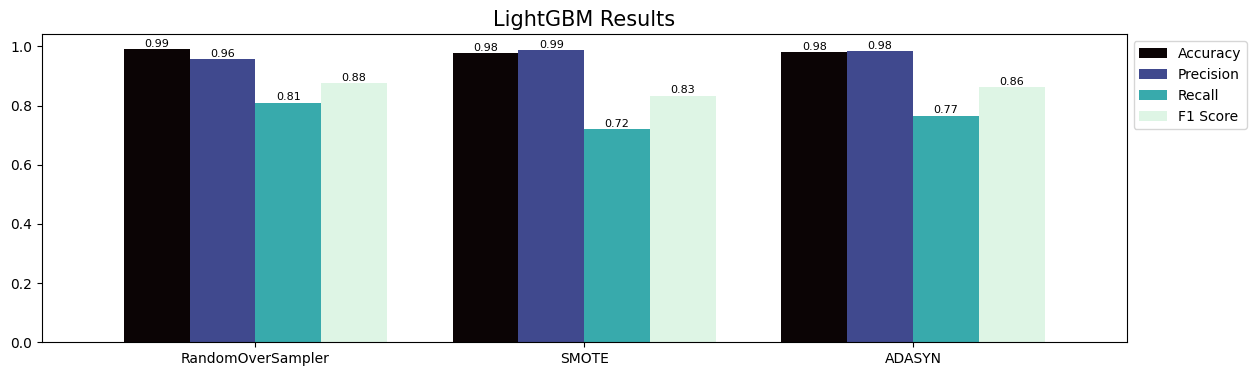

In [57]:
resplot(lgbmres, 'LightGBM Results')

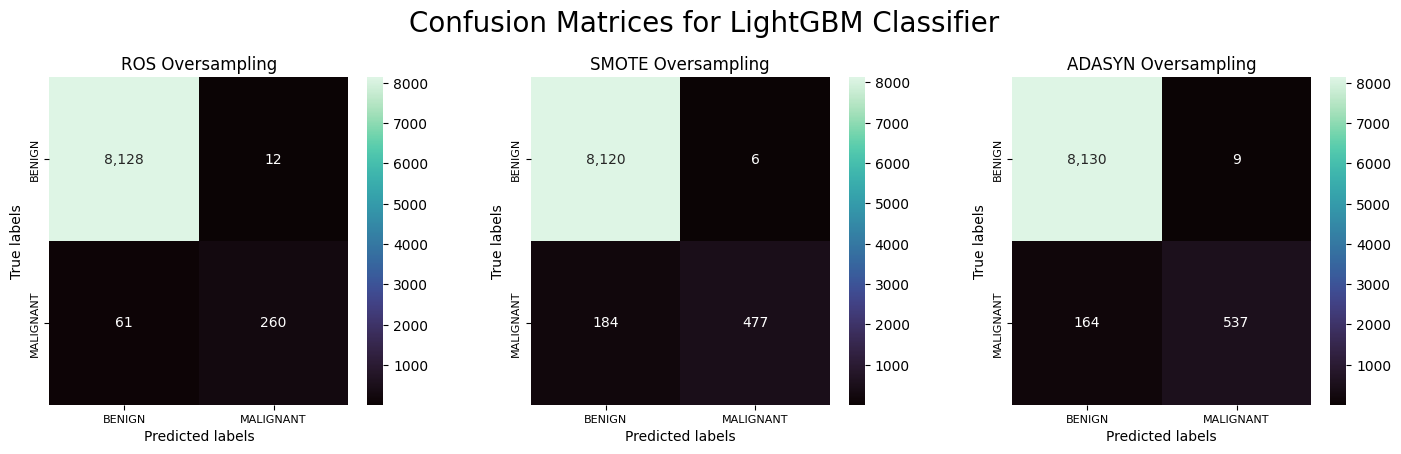

In [58]:
plot_confusion_grid(0,0, cm=cmm, t='Confusion Matrices for LightGBM Classifier')

  * We can see that Light GBM clasifier perfoms well for all the oversampling techniques, having a ~0.85 f1 score for each ROS, SMOTE and ADASYN.
  * This might be due to overfitting, as the samples are randomly duplicated for ROS and specific samples are selected in SMOTE. In ADASYN however, the samples are generated so the greater accuracy is good to see.

In [59]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'LGBM CM with {ost[n]} oversampling', cm=i)

## AdaBoost Classifier

In [63]:
cmm=[]
tr = DecisionTreeClassifier(max_depth=3)
clf= AdaBoostClassifier(estimator=tr, n_estimators=100, learning_rate=0.1)
adares=[]
for i in ost:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    adares.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Oversampling :")
    # report(y_test[i], y_pred)
    # print("\n")


In [64]:
adares=pd.DataFrame(adares)
adares.index=ostindex
adares.columns=metric
adares

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.965016,0.962963,0.080997,0.149425
SMOTE,0.973711,0.979911,0.664145,0.791704
ADASYN,0.971380,0.997778,0.640514,0.780191


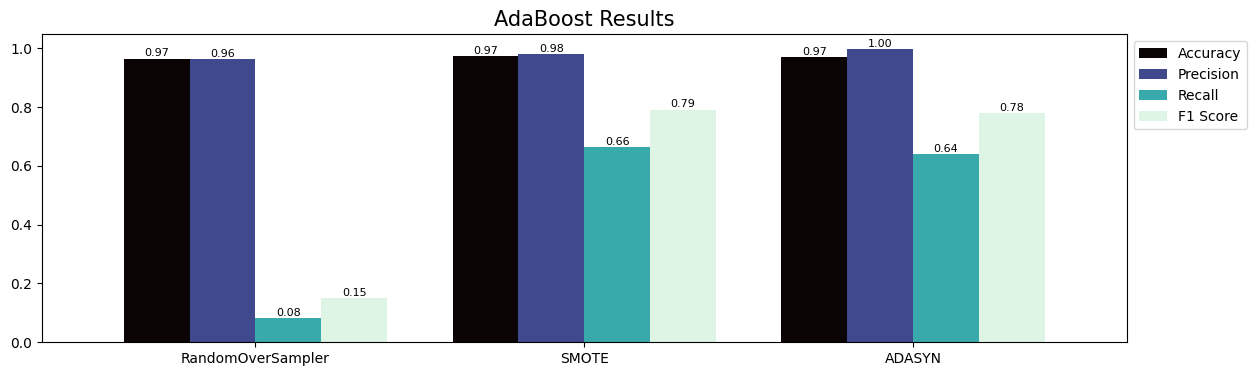

In [65]:
resplot(adares, 'AdaBoost Results')

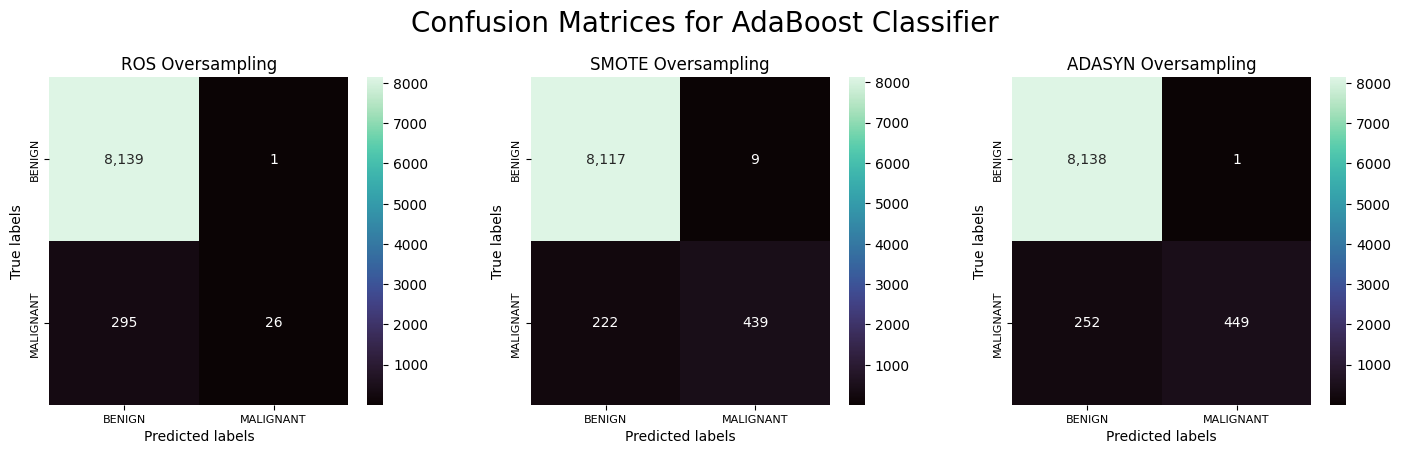

In [66]:
plot_confusion_grid(0,0, cm=cmm, t='Confusion Matrices for AdaBoost Classifier')

* ADABoost perfoms decent for SMOTE and ADASYN oversampling techniques, having a ~0.8 f1 score for each SMOTE and ADASYN.
* It does not perform well for ROS, which was a surprise. 
* It had a very low recall for the ROS technique, which might be due to the fact that it got overly trained on the majority class and hence it was unable to classify the minorty class properly

In [67]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'Adaboost CM with {ust[n]} oversampling', cm=i)


## Catboost Classifier

In [69]:
cmm=[]
cbcres=[]
clf= CBC(learning_rate=0.1)
for i in ost:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    cbcres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" combisampling :")
    # drep[f'CB-{i}'] = report(y_test[i], y_pred)
    # print("\n")
# cmd['CB']=cmm

0:	learn: 0.5502382	total: 188ms	remaining: 3m 7s
1:	learn: 0.4490721	total: 209ms	remaining: 1m 44s
2:	learn: 0.3679603	total: 226ms	remaining: 1m 14s
3:	learn: 0.3136931	total: 243ms	remaining: 1m
4:	learn: 0.2742217	total: 265ms	remaining: 52.6s
5:	learn: 0.2445099	total: 281ms	remaining: 46.5s
6:	learn: 0.2202636	total: 299ms	remaining: 42.4s
7:	learn: 0.2030203	total: 316ms	remaining: 39.2s
8:	learn: 0.1897450	total: 333ms	remaining: 36.7s
9:	learn: 0.1805847	total: 353ms	remaining: 35s
10:	learn: 0.1735492	total: 371ms	remaining: 33.4s
11:	learn: 0.1682175	total: 389ms	remaining: 32s
12:	learn: 0.1632943	total: 410ms	remaining: 31.1s
13:	learn: 0.1598915	total: 428ms	remaining: 30.1s
14:	learn: 0.1569699	total: 445ms	remaining: 29.2s
15:	learn: 0.1544469	total: 463ms	remaining: 28.5s
16:	learn: 0.1525433	total: 482ms	remaining: 27.9s
17:	learn: 0.1506891	total: 500ms	remaining: 27.3s
18:	learn: 0.1494182	total: 517ms	remaining: 26.7s
19:	learn: 0.1477247	total: 536ms	remaining: 2

In [70]:
cbcres=pd.DataFrame(cbcres)
cbcres.index=ostindex
cbcres.columns=metric
cbcres

,Accuracy,Precision,Recall,F1 Score
RandomOverSampler,0.986290,0.963801,0.663551,0.785978
SMOTE,0.979970,0.991886,0.739788,0.847487
ADASYN,0.978054,0.984704,0.734665,0.841503


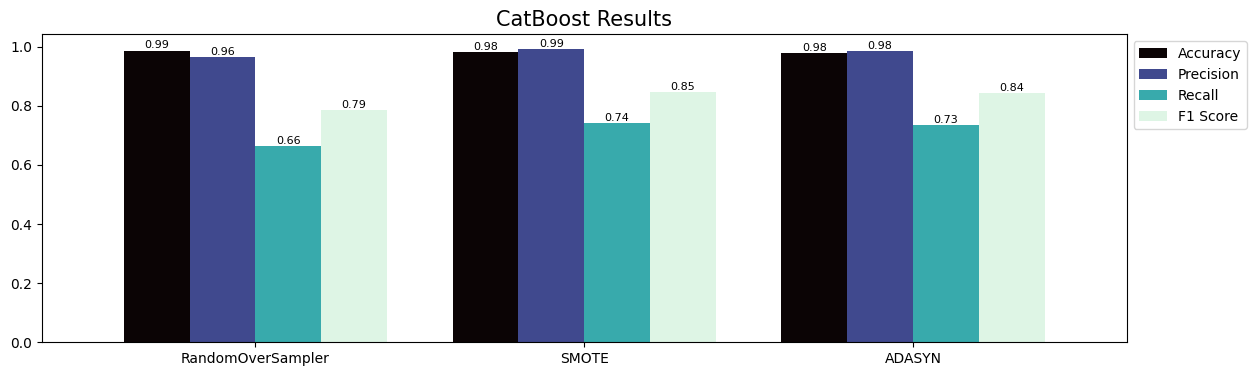

In [71]:
resplot(cbcres, 'CatBoost Results')

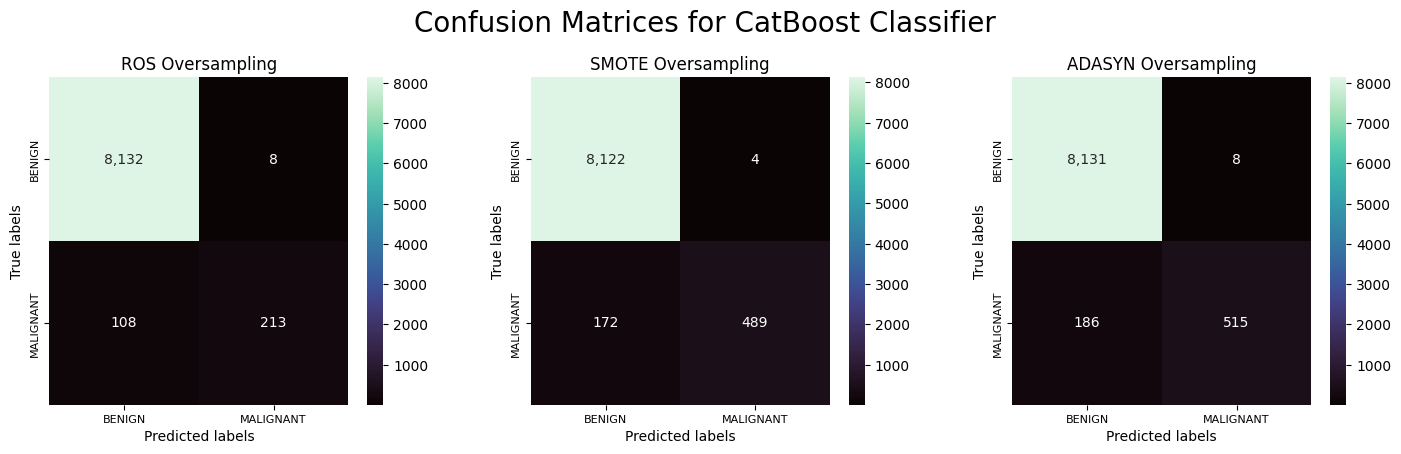

In [72]:
plot_confusion_grid(0,0, cm=cmm, t='Confusion Matrices for CatBoost Classifier')

* Catboost performs well for all the oversampling techniques. It has a ~0.85 f1 score for SMOTE and ADASYN, and 0.8 F1 score for ROS.

In [74]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'Catboost CM with {ost[n]} oversampling', cm=i)

# Conclusions:
Based on the above results, we can conclude that:
1. ADASYN Oversampling was the most consistent technique, giving good results for most of the models.
2. LightGBM and Catboost performed the best for all the oversampling techniques.
3. SVC and Logistic Regression performed the worst among all the models for all the oversampling techniques. This may be due to the fact that the dataset is not linearly separable enough for these models to perform well.
4. ROS, though it  produced good results on some models, it was inconsistent and the good results were probably due to overfitting and random duplication leading to greater recall.
